In [23]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [24]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [26]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [27]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)

In [28]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table

measurement = Base.classes.measurement
stations = Base.classes.station

In [30]:
# Create our session (link) from Python to the DB

session=Session(engine)

# Exploratory Precipitation Analysis

In [31]:
# Find the most recent date in the data set.

session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

Query Date:  2016-08-22


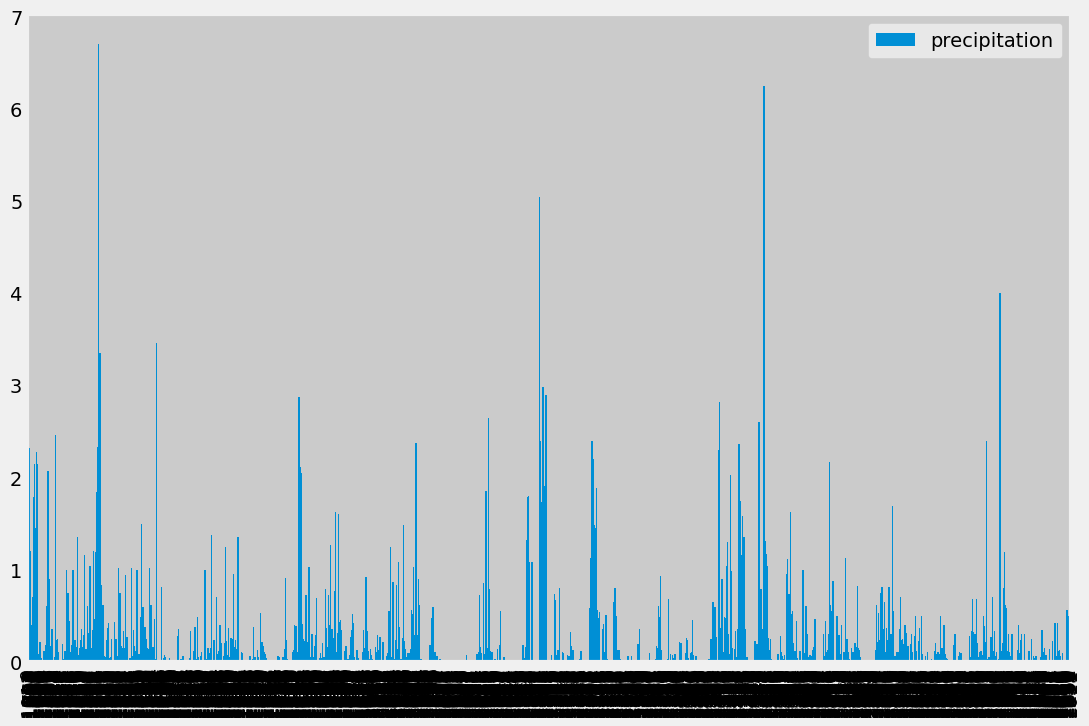

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

max_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

# Starting from the most recent data point in the database. 

session.query(measurement.date).order_by(measurement.date.desc()).first()


# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=366)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores

query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= query_date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])


# Sort the dataframe by date

precipitation_df = precipitation_df.sort_values(by='date',ascending=True)
precipitation_df.head()


# Use Pandas Plotting with Matplotlib to plot the data

precip_plot = precipitation_df.plot(kind='bar', width=3, figsize=(12,8))

In [33]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_df.describe()

,precipitation
count,2026.000000
mean,0.179437
std,0.463989
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [34]:
# Design a query to calculate the total number stations in the dataset

session.query(stations.id).count()

9

In [35]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

activity_stations = session.query(measurement.station, func.count(measurement.station)).\
                  order_by(func.count(measurement.station).desc()).\
                  group_by(measurement.station).\
                  all()
# List the stations and the counts in descending order.
activity_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Based on previous query, identify the most active
most_active_station = activity_stations[0][0]

# Calculate lowest temp recorded at station USC00519281
min_temp = session.query(func.min(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()
              
print(f"Lowest temperature at {most_active_station}: {min_temp}F.")

# Calculate max temp recorded at station USC00519281
max_temp = session.query(func.max(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

print(f"Highest temperature at {most_active_station}: {max_temp}F.")

# Calculate average temp recorded at station USC00519281
avg_temp = session.query(func.avg(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

print(f"Average temperature at {most_active_station}: {round(avg_temp, 2)}F.")

Lowest temperature at USC00519281: 54.0F.
Highest temperature at USC00519281: 85.0F.
Average temperature at USC00519281: 71.66F.


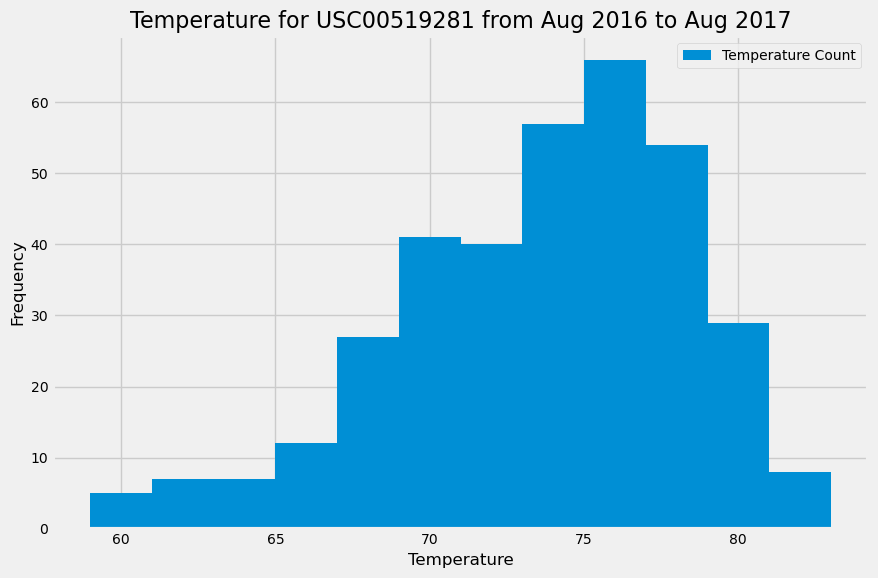

In [44]:
# Format max_date as string
max_date_str = max_date.strftime("%Y-%m-%d")

most_act_station = pd.DataFrame(session.query(measurement.tobs).\
                                filter(measurement.station == most_active_station).\
                                filter(measurement.date <= max_date_str).\
                                filter(measurement.date >= query_date).all())

most_act_station.plot(kind="hist", figsize=(9,6), bins=12, legend=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(['Temperature Count'], loc='upper right', fontsize=10)
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title(f"Temperature for {most_active_station} from Aug 2016 to Aug 2017", fontsize=16)

plt.tight_layout()
plt.savefig("USC00519281_temps.png")
plt.show()


# Close Session

In [45]:
# Close Session
session.close()